In [ ]:
import joblib
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from time                    import time
from tabulate                import tabulate
from sklearn.svm             import SVC
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics         import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Đọc file dữ liệu đã tiền xử lý
df = pd.read_csv('Churn_Cleaned.csv')
df

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,-1.280248,-1.161694,-0.994194,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0,0.064303,-0.260878,-0.173740,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,0,-1.239504,-0.363923,-0.959649,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0,0.512486,-0.747850,-0.195248,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,0,-1.239504,0.196178,-0.940457,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0,-0.343137,0.664868,-0.129180,0,True,True,True,True,False,...,False,True,False,True,True,False,True,False,False,True
7028,0,1.612573,1.276493,2.241056,0,False,True,True,True,False,...,False,True,False,True,True,False,True,True,False,False
7029,0,-0.872808,-1.170004,-0.854514,0,False,True,True,False,True,...,False,False,False,False,False,False,True,False,True,False
7030,1,-1.158016,0.319168,-0.872095,1,True,True,False,True,False,...,False,False,False,False,False,False,True,False,False,True


In [ ]:
# Chuẩn bị dữ liệu cho mô hình huấn luyện
df_X = df.drop('Churn', axis=1)          # tất cả đặc trưng
df_y = df['Churn'].astype(int)           # nhãn Churn (0/1)

# Khởi tạo Stratified K-Fold (10 fold)
skf  = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Tạo các list để lưu dữ liệu từng fold
X_train, X_test, y_train, y_test = [], [], [], []

for train_index, test_index in skf.split(df_X, df_y):
    Xfold_train = df_X.iloc[train_index]
    Xfold_test  = df_X.iloc[test_index]
    yfold_train = df_y.iloc[train_index]
    yfold_test  = df_y.iloc[test_index]

    X_train.append(Xfold_train)
    X_test.append(Xfold_test)
    y_train.append(yfold_train)
    y_test.append(yfold_test)

In [ ]:
# Định nghĩa 3 mô hình
models = {
    'KNN'          : KNeighborsClassifier(n_neighbors=5),
    'SVM'          : SVC(kernel='rbf', C=1, gamma='scale', probability=False),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
}

# Tạo dictionary để lưu kết quả trung bình của từng mô hình
results = {
    'KNN'          : {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-score': [], 'traintime': []},
    'SVM'          : {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-score': [], 'traintime': []},
    'Random Forest': {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-score': [], 'traintime': []}
}

# Đánh giá từng mô hình
for model_name, model in models.items():
    print(f'\n===== MÔ HÌNH: {model_name} =====')

    # Các list lưu kết quả từng fold
    accuracy   = []
    precision  = []
    recall     = []
    f1score    = []
    traintime  = []

    # List để in bảng
    tb         = []

    for fold in range(10):
        # Đo thời gian huấn luyện
        start_time = time()

        # Huấn luyện
        model.fit(X_train[fold], y_train[fold])

        end_time   = time()
        train_tim  = end_time - start_time

        # Dự đoán
        y_pred     = model.predict(X_test[fold])

        # Tính các độ đo
        acc = accuracy_score(y_test[fold], y_pred)
        pre = precision_score(y_test[fold], y_pred, zero_division=0)
        rec = recall_score(y_test[fold], y_pred, zero_division=0)
        f1  = f1_score(y_test[fold], y_pred, zero_division=0)

        # Lưu kết quả
        accuracy.append(acc)
        precision.append(pre)
        recall.append(rec)
        f1score.append(f1)
        traintime.append(train_tim)

        # Thêm dòng vào bảng
        tb.append([
            fold + 1,
            f'{acc:.4f}',
            f'{pre:.4f}',
            f'{rec:.4f}',
            f'{f1:.4f}',
            f'{train_tim:.4f}'
        ])

    # Tính trung bình và độ lệch chuẩn
    mean_acc = np.mean(accuracy)
    mean_pre = np.mean(precision)
    mean_rec = np.mean(recall)
    mean_f1  = np.mean(f1score)
    mean_tim = np.mean(traintime)

    std_acc  = np.std(accuracy)
    std_pre  = np.std(precision)
    std_rec  = np.std(recall)
    std_f1   = np.std(f1score)
    std_tim  = np.std(traintime)

    # Lưu trung bình vào results để vẽ biểu đồ sau
    results[model_name]['Accuracy'].append(mean_acc)
    results[model_name]['Precision'].append(mean_pre)
    results[model_name]['Recall'].append(mean_rec)
    results[model_name]['F1-score'].append(mean_f1)
    results[model_name]['traintime'].append(mean_tim)

    # Thêm dòng trung bình ± std
    tb.append([
        'Trung bình',
        f'{mean_acc:.4f} ± {std_acc:.4f}',
        f'{mean_pre:.4f} ± {std_pre:.4f}',
        f'{mean_rec:.4f} ± {std_rec:.4f}',
        f'{mean_f1:.4f}  ± {std_f1:.4f}',
        f'{mean_tim:.4f} ± {std_tim:.4f}'
    ])

    # In bảng kết quả
    print(f'CÁC ĐỘ ĐO CHO MÔ HÌNH {model_name.upper()} QUA 10 FOLD:')
    print(tabulate(
        tb,
        headers=['Fold', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Time (giây)'],
        tablefmt='fancy_grid'
    ))
    print('-' * 70)


===== MÔ HÌNH: KNN =====
CÁC ĐỘ ĐO CHO MÔ HÌNH KNN QUA 10 FOLD:
╒════════════╤═════════════════╤═════════════════╤═════════════════╤══════════════════╤═════════════════╕
│ Fold       │ Accuracy        │ Precision       │ Recall          │ F1-score         │ Time (giây)     │
╞════════════╪═════════════════╪═════════════════╪═════════════════╪══════════════════╪═════════════════╡
│ 1          │ 0.7784          │ 0.5975          │ 0.5080          │ 0.5491           │ 0.0256          │
├────────────┼─────────────────┼─────────────────┼─────────────────┼──────────────────┼─────────────────┤
│ 2          │ 0.7713          │ 0.5739          │ 0.5401          │ 0.5565           │ 0.0129          │
├────────────┼─────────────────┼─────────────────┼─────────────────┼──────────────────┼─────────────────┤
│ 3          │ 0.7610          │ 0.5523          │ 0.5108          │ 0.5307           │ 0.0117          │
├────────────┼─────────────────┼─────────────────┼─────────────────┼──────────────────┼

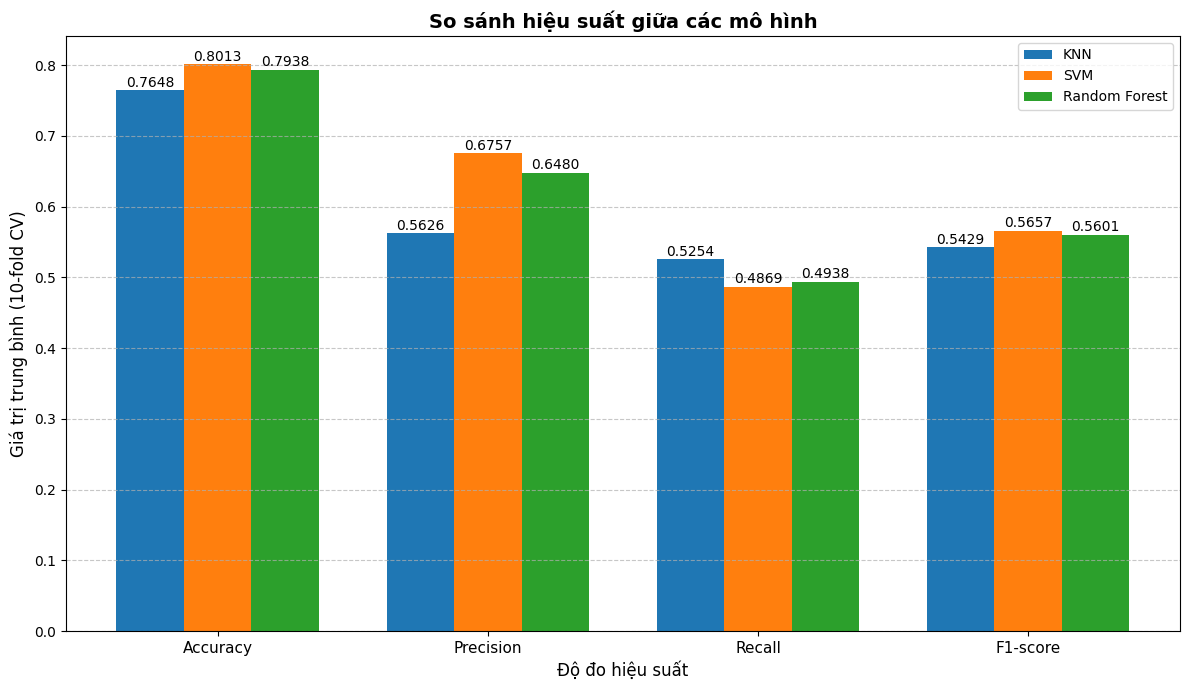

In [ ]:
# Vẽ biểu đồ so sánh các mô hình theo từng độ đo
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
x       = np.arange(len(metrics))
width   = 0.25

# Lấy dữ liệu đúng cấu trúc
knn_scores = [
    results['KNN']['Accuracy'][0],
    results['KNN']['Precision'][0],
    results['KNN']['Recall'][0],
    results['KNN']['F1-score'][0]
]

svm_scores = [
    results['SVM']['Accuracy'][0],
    results['SVM']['Precision'][0],
    results['SVM']['Recall'][0],
    results['SVM']['F1-score'][0]
]

rf_scores  = [
    results['Random Forest']['Accuracy'][0],
    results['Random Forest']['Precision'][0],
    results['Random Forest']['Recall'][0],
    results['Random Forest']['F1-score'][0]
]

fig, ax = plt.subplots(figsize=(12, 7))

ax.bar(x - width, knn_scores, width, label='KNN')
ax.bar(x,         svm_scores, width, label='SVM')
ax.bar(x + width, rf_scores,  width, label='Random Forest')

ax.set_xlabel('Độ đo hiệu suất', fontsize=12)
ax.set_ylabel('Giá trị trung bình (10-fold CV)', fontsize=12)
ax.set_title('So sánh hiệu suất giữa các mô hình', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Hiển thị giá trị
for i in range(len(metrics)):
    ax.text(i - width, knn_scores[i] + 0.005, f'{knn_scores[i]:.4f}', ha='center')
    ax.text(i,         svm_scores[i] + 0.005, f'{svm_scores[i]:.4f}', ha='center')
    ax.text(i + width, rf_scores[i]  + 0.005, f'{rf_scores[i]:.4f}',  ha='center')

plt.tight_layout()
plt.show()

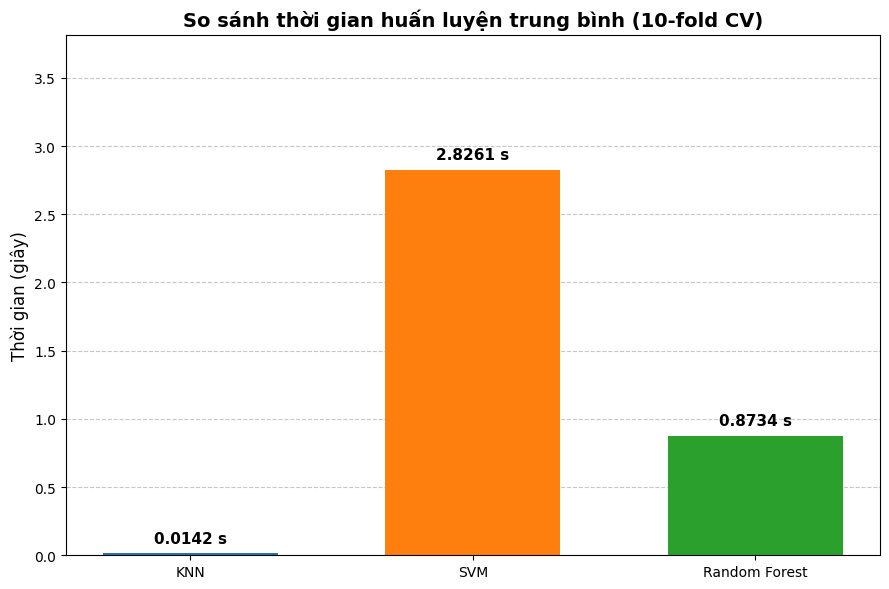

In [ ]:
# Vẽ biểu đồ so sánh thời gian huấn luyện trung bình
models = ['KNN', 'SVM', 'Random Forest']

# Lấy thời gian trung bình từ results
train_times = [
    results['KNN']['traintime'][0],
    results['SVM']['traintime'][0],
    results['Random Forest']['traintime'][0]
]

fig, ax = plt.subplots(figsize=(9, 6))

bars = ax.bar(models, train_times,
              color=['#1f77b4', '#ff7f0e', '#2ca02c'],
              width=0.62)

ax.set_title('So sánh thời gian huấn luyện trung bình (10-fold CV)',
             fontsize=14, fontweight='bold')
ax.set_ylabel('Thời gian (giây)', fontsize=12)
ax.set_ylim(0, max(train_times) * 1.35)  # để có không gian ghi số

# Ghi giá trị lên đầu mỗi cột
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + max(train_times)*0.02,
            f'{height:.4f} s',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

In [ ]:
# Sử dụng GridSearchCV để tìm một bộ tham số cho mô hình Random Forest

# Khởi tạo tham số
parameters = {
    'n_estimators'     : [50, 100, 200],     # Số lượng cây quyết định
    'max_depth'        : [None, 10, 20],     # Độ sâu tối đa của cây
    'min_samples_split': [2, 5, 10],         # Số mẫu tối thiểu để chia node
    'min_samples_leaf' : [1, 2, 4]           # Số mẫu tối thiểu tại lá
}

# Khởi tạo GridSearchCV
gridsearch     = GridSearchCV(
    estimator  = RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid = parameters,
    cv         = StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring    = 'accuracy',
    verbose    = 2,
    refit      = True,
    n_jobs     = -1
)

# Fit GridSearchCV trên fold đầu tiên
gridsearch.fit(X_train[0], y_train[0])

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=2)

In [ ]:
# In kết quả tốt nhất
best_params = gridsearch.best_params_
print("\nBộ tham số tốt nhất tìm được:")
print(best_params)
print(f"\nĐộ chính xác trung bình tốt nhất (trên 5-fold CV): {gridsearch.best_score_:.4f}")


Bộ tham số tốt nhất tìm được:
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}

Độ chính xác trung bình tốt nhất (trên 5-fold CV): 0.8075


In [ ]:
# Lấy mô hình Random Forest tốt nhất đã được refit tự động
rf_tuned = gridsearch.best_estimator_

# Đánh giá lại toàn bộ 10 fold với mô hình đã tune
accuracy_list   = []
precision_list  = []
recall_list     = []
f1_list         = []
traintime_list  = []

tb              = []

for fold in range(10):
    start_time  = time()

    # Huấn luyện
    rf_tuned.fit(X_train[fold], y_train[fold])

    end_time    = time()
    train_tim   = end_time - start_time

    # Dự đoán
    y_pred      = rf_tuned.predict(X_test[fold])

    # Tính các độ đo
    acc = accuracy_score(y_test[fold], y_pred)
    pre = precision_score(y_test[fold], y_pred, zero_division=0)
    rec = recall_score(y_test[fold], y_pred, zero_division=0)
    f1  = f1_score(y_test[fold], y_pred, zero_division=0)

    accuracy_list.append(acc)
    precision_list.append(pre)
    recall_list.append(rec)
    f1_list.append(f1)
    traintime_list.append(train_tim)

    tb.append([
        fold + 1,
        f'{acc:.4f}',
        f'{pre:.4f}',
        f'{rec:.4f}',
        f'{f1:.4f}',
        f'{train_tim:.4f}'
    ])

# Tính trung bình và độ lệch chuẩn
mean_acc = np.mean(accuracy_list)
mean_pre = np.mean(precision_list)
mean_rec = np.mean(recall_list)
mean_f1  = np.mean(f1_list)
mean_tim = np.mean(traintime_list)

std_acc  = np.std(accuracy_list)
std_pre  = np.std(precision_list)
std_rec  = np.std(recall_list)
std_f1   = np.std(f1_list)
std_tim  = np.std(traintime_list)

# Thêm dòng trung bình
tb.append([
    'Trung bình',
    f'{mean_acc:.4f} ± {std_acc:.4f}',
    f'{mean_pre:.4f} ± {std_pre:.4f}',
    f'{mean_rec:.4f} ± {std_rec:.4f}',
    f'{mean_f1:.4f}  ± {std_f1:.4f}',
    f'{mean_tim:.4f} ± {std_tim:.4f}'
])

# In bảng kết quả đầy đủ
print(f'CÁC ĐỘ ĐO CHO MÔ HÌNH RANDOM FOREST SAU KHI TUNE QUA 10 FOLD:')
print(tabulate(
    tb,
    headers=['Fold', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Time (giây)'],
    tablefmt='fancy_grid'
))

CÁC ĐỘ ĐO CHO MÔ HÌNH RANDOM FOREST SAU KHI TUNE QUA 10 FOLD:
╒════════════╤═════════════════╤═════════════════╤═════════════════╤══════════════════╤═════════════════╕
│ Fold       │ Accuracy        │ Precision       │ Recall          │ F1-score         │ Time (giây)     │
╞════════════╪═════════════════╪═════════════════╪═════════════════╪══════════════════╪═════════════════╡
│ 1          │ 0.7955          │ 0.6443          │ 0.5134          │ 0.5714           │ 0.6295          │
├────────────┼─────────────────┼─────────────────┼─────────────────┼──────────────────┼─────────────────┤
│ 2          │ 0.8139          │ 0.6918          │ 0.5401          │ 0.6066           │ 0.4709          │
├────────────┼─────────────────┼─────────────────┼─────────────────┼──────────────────┼─────────────────┤
│ 3          │ 0.8023          │ 0.6794          │ 0.4785          │ 0.5615           │ 0.2729          │
├────────────┼─────────────────┼─────────────────┼─────────────────┼──────────────────┼───

In [ ]:
# Lưu các mô hình đã huấn luyện ra file mới
# KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(df_X, df_y)

# SVM
svm_model = SVC(kernel='rbf', C=1, gamma='scale', probability=False)
svm_model.fit(df_X, df_y)

# Random Forest
rf_tuned = gridsearch.best_estimator_
rf_tuned.fit(df_X, df_y)

# Lưu ra 3 file mới
joblib.dump(knn_model, 'knn_model.pkl')
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(rf_tuned,  'rf_tuned_model.pkl')

['rf_tuned_model.pkl']